# MuMoT Tutorial SIAM LS18 Conference  <a class="tocSkip">

## MuMoT: Multiscale Modelling Tool  <a class="tocSkip">

A software tool developed at the University of Sheffield as part of the [DiODe](http://diode.group.shef.ac.uk) project.

## Working with MuMoT<a class="tocSkip">

MuMoT runs inside [Jupyter notebooks](http://jupyter.org) - since you are reading this User Manual you have presumably already installed Jupyter, or are using an installation provided to you. To toggle the [table of contents](https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tree/master/src/jupyter_contrib_nbextensions/nbextensions/toc2) click the 'Table of Contents' button in the Jupyter toolbar.

Next, you need to install MuMoT itself; since MuMoT is a Python package it can be installed from PyPi - see the [project documentation](https://diodeproject.github.io/MuMoT/getting_started.html) for more details.

To run commands in 'Code' cells it's usually easiest just to hit `Shift + Enter`; here is some basic information on [working with Jupyter notebooks](http://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Notebook%20Basics.html).

With Jupyter and MuMoT both installed, you simply need to import the MuMoT package into your notebook using `import mumot`.

In [1]:
import mumot
mumot.about()

Created `%%model` as an alias for `%%latex`.
Multiscale Modelling Tool (MuMoT): Version 0.1.0-dev
Authors: James A. R. Marshall, Andreagiovanni Reina, Thomas Bose
Documentation: https://diodeproject.github.io/MuMoT


## Defining the model<a class="tocSkip">

MuMoT models are defined using the `%%model` keyword within a cell, and have a straightforward syntax; you simply have to describe the reactions that take place, and the rates with which they occur.

Our model will be based on signalling behaviour observed in honeybee swarms, as described in Seeley et al., *Science* 335: 108 (2012) and Pais et al., *PLOS ONE* 8, e73216 (2013); see also Reina et al., *Phys. Rev. E* 95, 052411 (2017) for 3 or more alternatives.

Here we go...

In [2]:
%%model
$
U -> A : g_A
U -> B : g_B
A -> U : a_A
B -> U : a_B
A + U -> A + A : r_A
B + U -> B + B : r_B
A + B -> A + U : \sigma
A + B -> B + U : \sigma
$

<IPython.core.display.Latex object>

Now we have our model, and Jupyter should have reprinted the rules underneath the cell you input them in.

You can see that actually the `_` code enables you to use subscripts, which can be handy for distinguishing related rates - in this model there are two distinct nest sites for the honeybee swarm to choose between, *A* and *B*, and rates associated with each one.

To make one of those we have to use the `parseModel` command; we simply pass in a reference to the cell where we defined our model - this should be in input cell 2...

In [3]:
model1 = mumot.parseModel(In[2])

Now we have `model1`, which is a version of the model that we can start doing useful work with. 

We can also look at the reaction equations in a slightly nicer format...

In [4]:
model1.show()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

We can even see a simple figure representing our model...

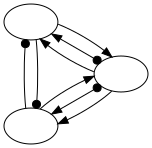

In [5]:
model1.visualise()

This figure attempts to represent the nature of the interactions between reactants graphically, from simple transitions (arrows), inhibitions (filled circles) and induced switches (arrows with filled circles at the origin).

## Exploring the model<a class="tocSkip">

A first useful command is `showODEs()`

In [ ]:
model1.showODEs()

So, what analysis can we do in MuMoT now we've found our ODEs?

First we can symplify them.

In what follows we assume that the system is conserved and let MuMoT know this by defining one of the reactants in terms of the other, using `substitute()`

In [ ]:
model2 = model1.substitute('U = N - A - B')

Now we have a simplified model, `model2`, which only has two equations.

In [ ]:
model2.showODEs()

Having a closer look at these equations, we see that $U$ has vanished from the equations. 

Symbols denoting *reactants* in the ODEs are *concentrations*, as their derivation is based on the **law of mass action**: *the rate with which a chemical reaction occurrs is proportional to (the product of) the concentration of the reactants.* This can be made clearer by deriving the ODEs via a principled method based on the system size expansion (also called *van Kampen* expansion (van Kampen, *Stochastic Processes in Physics and Chemistry* (2007)) of the *Master equation* explained below. In MuMoT we can use `showODEs()` with the keyword `method='vanKampen'` - here is an example: 

In [ ]:
model2.showODEs(method='vanKampen')

As you can see, we use the upper-case Greek letter $\Phi$ to denote concentrations (proportions) and the reactants are added as indices. This is done throughout MuMoT and you will encounter this notation again when you work with the tool.

This shall be enough about mathematical equations for now; let's turn to more exciting graphical output and numerically integrate the ODEs using the MuMoT-method `integrate()`

In [ ]:
int1 = model2.integrate()

Jupyter also lets you interact nicely with the figure; you can zoom in, back out, pan around, and save, all by clicking the icons that appear underneath it. If you want to save a figure for a paper, simply click the disk icon. 

Every *controller* in MuMoT keeps a log of everything it's been asked to do; we called our controller `int1` when we created it, so it is easy to check what it has been up to...

In [ ]:
int1.showLogs(tail = True)

To continue our analysis we may reduce the number of parameters. We might choose to describe some of the rates (abandonment (*a*), recruitment (*r*, via the waggle dance), and individual discovery and commitment (*g*)) in terms of the values (*v*) of the nest sites... we can do this by using `substitute()` again:

In [ ]:
model3 = model2.substitute('a_A = 1/v_A, a_B = 1/v_B, g_A = v_A, g_B = v_B, r_A = v_A, r_B = v_B')

Our new model is a little simpler, with just three rates, $v_A$, $v_B$ and $\sigma$.

In [ ]:
model3.show()

Still, in decision-making what we really care about is how good options are on average, and their difference in value. Pais et al. (PLOS ONE 8, e73216 (2013)) thus defined option values in terms of deviation from the average value, so
$$\displaystyle v_A=\mu+\frac{\Delta}{2}$$
and
$$\displaystyle v_B=\mu-\frac{\Delta}{2}$$

In [ ]:
model4 = model3.substitute('v_A = \mu + \Delta/2, v_B = \mu - \Delta/2')
model4.showODEs()

This model is much easier to interact with, as the following `stream` plot demonstrates...

In [ ]:
stream1 = model4.stream('A','B', showFixedPoints = True, initWidgets={'mu':[3, 1, 5, 0.5],'Delta':[0, 0, 3, 0.1]})

A `stream` plot is just like a `vector` plot, except now lines show the average change of the system over time in more detail, and their shading represents the speed of change, from slow (light grey) to fast (black).

Further analysis can be done via *bifurcation plots*, using the `bifurcation()` command...

`bifurcation()` takes two primary arguments, the first is the parameter we want to vary systematically, the second is the state we want to observe.    

In [ ]:
bifurcation1 = model4.bifurcation('\\sigma','A-B', 
                                  initWidgets={'mu':[3, 1, 5, 0.5], 'Delta':[0, 0, 2, 0.1], 
                                               'initBifParam':[4.5, 4, 6, 0.1]},
                                 choose_xrange=[0, 5])

In the `bifurcation()` command above we specified initial parameter values (and ranges) for the sliders (via `initWidgets={...}`) and the range shown on the x-axis (with `choose_xrange=[xmin, xmax]`), which yields appropriate results straight away. 

Our plot shows the location of fixed points, and they are either depicted as *stable* (solid line) or *unstable* (dashed line). The label *BP1* means there is 1 occurrence of a *branch point*. This type of bifurcation is referred to as a *pitchfork bifurcation*. 

As a next step, move the $\Delta$-slider to 0.1 and observe an *unfolding* of the *pitchfork bifurcation* where the branches become disconnected and instead of a *branch point* a *limit point* (*LP1*) is now detected (this computation may take some time).

### Unfolding of pitchfork bifurcation ($\Delta =0.1$)<a class="tocSkip">

<img src="UnfoldingDemoSIAMLS18.png", title="Unfolding-of-pitchfork",width=680, align="left">

## The effects of finite system size<a class="tocSkip">

The ODE models we have been looking at based on our model are very useful, but they represent an idealised scenario; they describe the behaviour of a system with infinitely many components or, to put it another way, the expected behaviour of the system, minus any noise.

Noise is very important in collective behavour systems, however, and can have a variety of causes. The first cause we will consider is noisy fluctuations from the infinite population ideal, caused by having a finite, much smaller, population. 

We concentrate first on statistical physics analysis based on deriving the *Master Equation*.

Master equations describe the time evolution of a system that, in general, can be in one of many different possible states at a given point in time with a certain probability. Over time, the system makes transitions so that the overall state changes continuously. Transitions are governed by transition probabilities that are usually summarised in a transition matrix. The Master equation is a set of first-order differential equations that describe the evolution of the state dependent probabilities driven by the transition matrix.

The *chemical Master equation* (van Kampen, *Stochastic Processes in Physics and Chemistry* (2007)) is a master equation for the probabilities that the system has any given composition of rectants as a function of time. In MuMoT this equation can be derived using:

In [ ]:
model1.showMasterEquation()

Here *step operators* $E_{op}$ are used to express the chemical Master equation in a compact form. MuMoT implements the derivation of the Master equation as shown by van Kampen (*Stochastic Processes in Physics and Chemistry* (2007)).

Now that we have derived the Master eqution for our model we can use it to obtain the *Fokker-Planck* equation:

In [ ]:
model1.showFokkerPlanckEquation()

In [ ]:
#model1.showNoiseEquations()

The Master equation may also be used to display noise around fixed points ...

In [ ]:
#stream2 = model4.stream('A','B', showFixedPoints = True, showNoise = True,
#                        initWidgets={'mu':[3, 1, 5, 0.5], 'Delta':[0, 0, 3, 0.1], 'systemSize':[60, 5, 100, 1]})

<img src="NoiseFPDemoSIAMLS18.png", title="Noise-around-fixedPoints",width=680, align="left">

This new `stream` plot now lets us see how the system's expected state gets 'spread out' around the fixed points. The extent of the spread depends on the number of components in the system.

The effects of noise in the `stream` plot above are based on the computational approximations of the Master Equation. MuMoT also gives direct access to a *Stochastic Simulation Algorithm* (SSA) (Gillespie, *J. Comput. Phys.* 22: 403 (1976)) simulator to visualise the behaviour of the system over time.

To run the SSA simulations on your model, you can use the command `SSA()`.

In [ ]:
ssa1 = model4.SSA(initWidgets={'initialState': {'U': [1,0,1,0.05], 'B': [0,0,1,0.05], 'A': [0,0,1,0.05]},
                              'systemSize':[50,5,100,1] })

To see how the stochastic simulation compares with the ODE solution we can overlay both ...

In [ ]:
silentIntegrate1 = model4.integrate(silent = True)
silentSSA1 = model4.SSA(silent = True)
mc1 = mmt.MuMoTmultiController([silentIntegrate1, silentSSA1], shareAxes = True,
                                initWidgets={'initialState':{'U': [1,0,1,0.01],'B': [0,0,1,0.01],
                                'A': [0,0,1,0.01]}, 'runs':[5,1,20,1], 'aggregateResults':True})

## Non-constant system size<a class="tocSkip">

A classic model from both ecology and chemistry is the *Lotka-Volterra* model; ecologists often think of this as representing two interacting populations, one of predators, and one of prey. Individuals are born and die in both populations. MuMoT enables this both via the `\emptyset` notation $\emptyset$, in which components spontaneously arise from nothing, or are destroyed, and via steady-state reactant populations, denoted with `()`, which do not change over time but simply persist at a constant size.

Our Lotka-Volterra example is taken from Murray (*Mathematical Biology* (2002), p124). Individuals are born into the prey population $X$ at a rate that depends on that population size, then predatory interactions decrease the prey population size and increase the predator population size. Finally, predators experience background mortality.

In [ ]:
%%model
$
(A) + X -> X + X : \alpha
X + Y -> Y + Y : \beta
Y -> \emptyset : \gamma
$

In [ ]:
model5 = mmt.parseModel(In[23])
model5.show()

In [ ]:
model5.showODEs()

Note that there is no equation for $A$; since it is specified to be at a constant concentration, it does not change over time. This means that when we try and interact with the model, we will need to specify the constant value that $A$ should take.

Also, since the system size is now no longer constant, as discussed above, it is useful to be able to change the limits on the plot, to ensure that all the interesting behaviour of the system is visible... the `Plot limits` widget enables this.

In [ ]:
stream3 = model5.stream('X','Y', showFixedPoints = False, xlab="prey", ylab="predator")

## Viewing the Master and Fokker-Planck equations, and calculating & displaying noise<a class="tocSkip">
<a id='masterEqFokkerPlanck'></a>

To show this functionality we make use of a model describing the production and decay of protein $P$ and its dimerization into $P_2$ (more conveniently called $X$ and $Y$ below), see Hayot & Jayaprakash, *Physical Biology* 1: 205-210 (2004) for details. This model is defined as:

In [ ]:
%%model
$
\emptyset -> X : k_3
X -> \emptyset : k
X + X -> Y + \emptyset : k_1
Y + \emptyset -> X + X : k_2
$

As you already know it from the examples above, let's parse the model ...

In [ ]:
model6 = mmt.parseModel(In[27])

Now that MuMoT knows the model, we can continue deriving the *chemical Master equation*. 

In [ ]:
model6.showMasterEquation()

Here, $P(X,Y,t)$ describes the probability of observing the systems's composition of reactants $X$ and $Y$ at time $t$. In MuMoT, the system size that, at this point, is not specified and which is used as a formal parameter for the system size expansion described below is denoted $\overline{V}$. Please pay attention to this notation if defining your model using the letter $V$ (but don't worry, MuMoT will not confuse both variables).

Here *step operators* $E_{op}$ are used to express the chemical Master equation in a compact form. MuMoT implements the derivation of the Master equation as shown by van Kampen (*Stochastic Processes in Physics and Chemistry* (2007)).

Unfortunately, there is only a limited number of simple cases that allow to solve the Master equation exactly. Hence, analytical approximations may help, such as the *system size expansion* (also called *van Kampen expansion*), which is implemented in MuMoT by `showVanKampenExpansion()`. 

The idea of this method is to expand the Master equation in powers of a small parameter, which is
<br>
$$\sim \frac{1}{\sqrt{system\, size}} \,.$$
<br>

Let's do the expansion with MuMoT and display it for the current model ($\overline{V}$ = system size):

In [ ]:
model6.showVanKampenExpansion()

This equation describes an expansion in the parameter $\overline{V}$, which represents the system size. We repeat that at this point this is not specified. However, often $\overline{V}$ is a volume or the total number of particles in a real system. For more information on the system size expansion refer to van Kampen (*Stochastic Processes in Physics and Chemistry* (2007)).

Collecting all terms $\propto \sqrt{\overline{V}}$ gives the ODEs, which can be displayed using:

In [ ]:
model6.showODEs(method='vanKampen')

Here, the $\Phi_{X,Y}$ once more describe the concentrations of $X$ and $Y$ in the mixture (i.e. $\Phi_{X}=X/\overline{V}$, for example).

Next, if we collect all terms $\propto \overline{V}$ we obtain the *Fokker-Planck equation* in the *linear noise approximation*:

In [ ]:
model6.showFokkerPlanckEquation()

This equation describes the probability of fluctuations $\eta_{X,Y}$ at time t. In MuMoT, fluctuations are automatically denoted $\eta$ with the index denoting the reactant. These quantities describe the fluctuations around the *mean field* value of the concentrations $\Phi_{X,Y}$. 

Having this equation allows us derive the equations of motion for the fluctuations. This can be done as follows:

In [ ]:
model6.showNoiseEquations()

Here, we have first-order moments, $\langle \eta_{X}\rangle$ and $\langle \eta_{Y}\rangle$, and second-order moments, $\langle \eta_{R_1}\eta_{R_2}\rangle$, where $R_{1,2}=X,Y$.

We can analytically derive the stationary solutions of these equations and display them using:

In [ ]:
model6.showNoiseSolutions()

Another possibility to study noise in the system is by calculating the time-dependent noise correlations according to:

In [ ]:
nc1 = model6.noiseCorrelations(initWidgets={'maxTime':[20,5,50,1]})

These correlation functions relate to fluctuations around a fixed point. To see the corresponding fixed point we can simply show the logs:

In [ ]:
nc1.showLogs()

Please keep this stationary state of the system in mind for a little moment.

We can also numerically integrate our dynamical system: 

In [ ]:
int2 = model6.integrate(initWidgets={'maxTime':[30,5,50,1]}, legend_loc='center right')

Now click on the *Advanced options* tab above the figure and tick the *Plot population proportions* tab. We then display the last point on the curve by showing the logs with the following command:

In [ ]:
int2.showLogs()

Here, you can see the last point on the curve before selecting to plot proportions and after choosing this option. Remember, the proportions are calculated by dividing the total numbers by the system size at t=0 (which, if you haven't changed anything, should equal 10 in the plot above -- see the *System size* slider above the figure). 

Note that the values on the sliders are the same as in the plot of the noise correlations above. If you could memorise the fixed point around which the correlation functions were plotted (if not, it was ($\Phi_X=1$, $\Phi_Y=1$)) and compare this with the last point on the curve above (see `int2.showLogs` above), we can safely say that both are in agreement. So, it works! The noise correlations have been plotted around the stationary state of the dynamical system. Using `integrate` we obtained a graphical confirmation of this.

## Going to a higher dimension<a class="tocSkip">
Our model above ended up being 2-dimensional, after we realised that there were a constant number of components in the system. However MuMoT can work with higher-dimensional models (although not all features are supported for them).

For example, we can consider the generalisation of `model1` above to 3 or more alternatives, as presented by Reina et al., *Phys. Rev. E* 95, 052411 (2017) ...

In [ ]:
%%model
$
U -> A : k * v_A
U -> B : k * v_B
U -> C : k * v_B
A -> U : k * (1 / v_A)
B -> U : k * (1 / v_B)
C -> U : k * (1 / v_C)
A + U -> A + A : h * v_A
B + U -> B + B : h * v_B
C + U -> C + C : h * v_C
A + B -> A + U : h * v_A
A + B -> B + U : h * v_B
A + C -> A + U : h * v_A
A + C -> C + U : h * v_C
B + C -> B + U : h * v_B
B + C -> C + U : h * v_C
$

In [ ]:
model7 = mmt.parseModel(In[39]).substitute('U = N - A - B - C')
vector2 = model7.vector('A', 'B', 'C')

## References<a class="tocSkip">
<a id='references'></a>
* Gillespie, D. T. (1976). A general method for numerically simulating the stochastic time evolution of coupled chemical reactions. *Journal of Computational Physics* **22** (4): 403–434
* Hayot, F. & C. Jayaprakash (2004) 
[The linear noise approximation for molecular fluctuations within cells](http://iopscience.iop.org/article/10.1088/1478-3967/1/4/002/pdf). *Physical Biology* **1**, 205-210
* Murray, J. D. (2002) *Mathematical Biology I. An Introduction (Second Edition)*. Springer
* Pais, D., Hogan, P.M., Schlegel, T., Franks, N.R., Leonard, N.E. & Marshall, J.A.R. (2013) [A mechanism for value-sensitive decision-making](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0073216).  *PLoS one* **8**(9), e73216
* Reina A., Valentini G., Fernández-Oto A., Dorigo M. & Trianni V. (2015) [A design pattern for decentralised decision making](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0140950).  *PLoS one* **10**(10), e0140950
* Reina A., Marshall J.A.R., Trianni V., Bose T. (2017) [Model of the best-of-N nest-site selection process in honeybees](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.95.052411) *Physical Review E* **95**: 052411
* Seeley, T.D, Visscher, P.K. Schlegel, T., Hogan, P.M., Franks, N.R. & Marshall, J.A.R. (2012) [Stop signals provide cross inhibition in collective decision-making by honeybee swarms](http://www.sciencemag.org/content/335/6064/108.full.pdf). *Science* **335**, 108-111
* van Kampen, N. (2007) *Stochastic Processes in Physics and Chemistry (Third Edition)*. North-Holland